Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [1]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
from glob import glob

In [3]:
if tf.test.gpu_device_name():
    print('Default GPU device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU device: /device:GPU:0


 C:\Users\ABHISHEK> python D:\CNN_assignment_dataset\test_gpu.py.txt
2022-04-18 14:20:35.040994: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-18 14:20:35.531460: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 2155 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5
2022-04-18 14:20:35.532227: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 2155 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5
Default GPU device: /device:GPU:0

In [4]:
#Train images
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration\Train")
#Test images
data_dir_test = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration\Test")

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

In [6]:
### Create a dataset: It's mentioned in the question to resize the images to 180*180 and the batch size to be 32.

#Define some parameters for the loader:

batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
            data_dir_train,
            class_names=None,
            color_mode='rgb',
            batch_size=batch_size,
            image_size=(img_height, img_width),
            shuffle=True,
            seed=123,
            validation_split=0.2,
            subset='training',
            interpolation='bilinear',
            follow_links=False,
            crop_to_aspect_ratio=False
            )

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
print(train_ds)

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
            data_dir_train,
            class_names=None,
            color_mode='rgb',
            batch_size=batch_size,
            image_size=(img_height, img_width),
            shuffle=True,
            seed=123,
            validation_split=0.2,
            subset='validation',
            interpolation='bilinear',
            follow_links=False,
            crop_to_aspect_ratio=False
            )

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


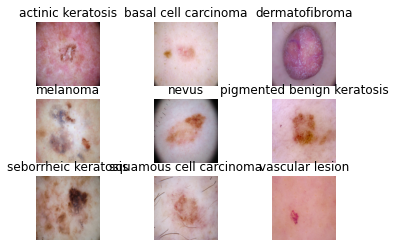

In [11]:
### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset
### your code goes here, you can use training or validation data to visualize

for i in range(len(class_names)):
    filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

The tf.data.Dataset.cache transformation can cache a dataset, either in memory or on local storage. This will save some operations (like file opening and data reading) from being executed during each epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

While the model is executing training step s, the input pipeline is reading the data for step s+1. Doing so reduces the step time to the maximum (as opposed to the sum) of the training and the time it takes to extract the data.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# M1 model

## Create the model

Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

Rescaling class
tf.keras.layers.Rescaling(scale, offset=0.0, **kwargs)
A preprocessing layer which rescales input values to a new range.

This layer rescales every value of an input (often an image) by multiplying by scale and adding offset.

For instance:

To rescale an input in the [0, 255] range to be in the [0, 1] range, you would pass scale=1./255.

To rescale an input in the [0, 255] range to be in the [-1, 1] range, you would pass scale=1./127.5, offset=-1.

The rescaling is applied both during training and inference. Inputs can be of integer or floating point dtype, and by default the layer will output floats.

# Example
num_class = 9
model = Sequential([
    layers.Rescaling(scale = 1./255, input_shape = (180,180,3)),
    layers.Conv2D(16,3,padding='same',activation= 'relu'),
    layers.Conv2D(32,3,padding='same',activation= 'relu'),
    layers.Conv2D(64,3,padding='same',activation= 'relu'),
    layers.Flatten()
    layers.Dense(128,activation='relu')
    layers.Dense(num_class)
])

### Your code goes here
Sequential([
    - rescaling
    - conv2d
    - MaxPool
    - conv2d
    - MaxPool
    - conv2d
    - MaxPool
    - Flatten
    - Dense
    - Dense
])

In [13]:
num_class = 9
model = tf.keras.Sequential()
model.add(layers.Rescaling(scale = 1./255, input_shape = (180,180,3)))
model.add(layers.Conv2D(16,3,padding='same',activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size = 2, strides = 2))    
model.add(layers.Conv2D(32,3,padding='same',activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size = 2, strides = 2))
model.add(layers.Conv2D(64,3,padding='same',activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size = 2, strides = 2))
model.add(layers.Flatten())
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dense(num_class))

Compile the model
Choose an appropirate optimiser and loss function for model training

In [14]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

# Train the model

In [16]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 11s 53ms/step - loss: 2.0350 - accuracy: 0.2729 - val_loss: 1.7799 - val_accuracy: 0.3043
Epoch 2/20
56/56 [==============================] - 2s 32ms/step - loss: 1.6599 - accuracy: 0.3962 - val_loss: 1.7033 - val_accuracy: 0.3781
Epoch 3/20
56/56 [==============================] - 2s 32ms/step - loss: 1.5573 - accuracy: 0.4548 - val_loss: 1.5105 - val_accuracy: 0.4899
Epoch 4/20
56/56 [==============================] - 2s 32ms/step - loss: 1.4326 - accuracy: 0.5067 - val_loss: 1.5101 - val_accuracy: 0.4944
Epoch 5/20
56/56 [==============================] - 2s 32ms/step - loss: 1.2996 - accuracy: 0.5374 - val_loss: 1.4968 - val_accuracy: 0.5056
Epoch 6/20
56/56 [==============================] - 2s 32ms/step - loss: 1.2519 - accuracy: 0.5642 - val_loss: 1.3381 - val_accuracy: 0.5436
Epoch 7/20
56/56 [==============================] - 2s 32ms/step - loss: 1.1454 - accuracy: 0.5954 - val_loss: 1.4929 - val_accuracy: 0.4922
Epoch 8/20
5

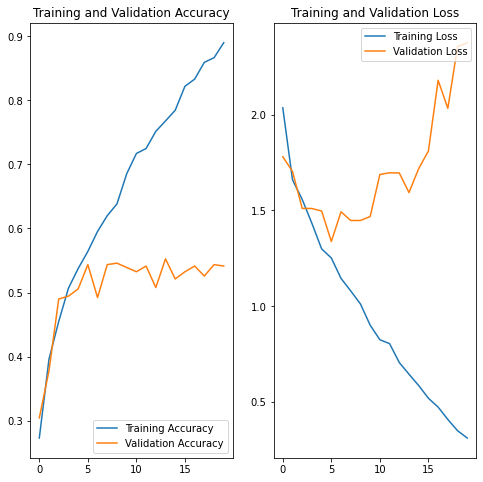

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Findings after the model fit, see if there is an evidence of model overfit or underfit:
* As we can see above that the model is showing signs of overfit as the training accuracy touches around 90% but the validation accuracy amount upto odd 50.
* Similarly with the losses, while the training losses drop per epoch, again the validation loss just climbs up and comes down a bit towards the end, still a stark difference between those two.

# M2 model

In [18]:
#choose an appropriate data augumentation strategy. 
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [19]:
print(train_ds)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


(32, 180, 180, 3)


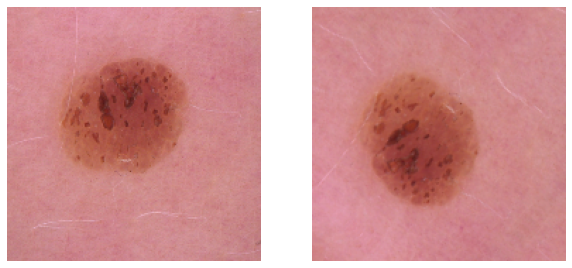

In [20]:
#visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    print(images.shape) #Should be 32 images present
    ax = plt.subplot(1, 2, 1)
    plt.imshow(images[0].numpy().astype("uint8"))
    plt.axis("off")
    augmented_images = data_augmentation(images)
    ax = plt.subplot(1, 2, 2)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")
    plt.show()

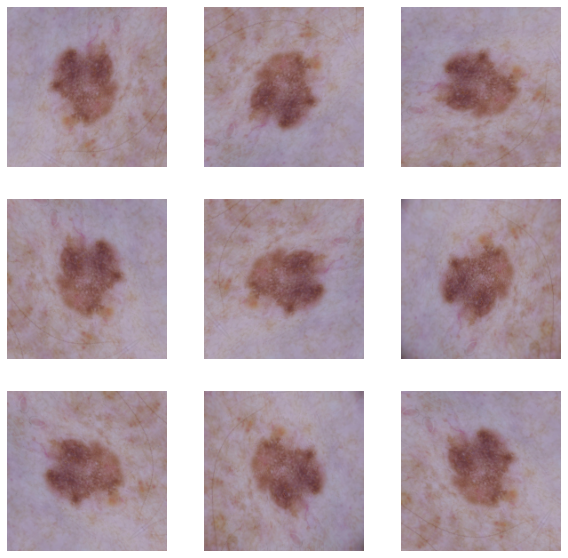

In [21]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

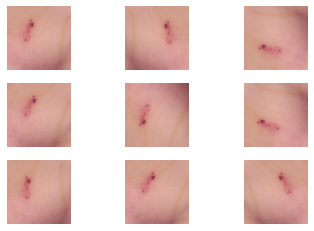

In [22]:
#visualize how your augmentation strategy works for one instance of training image of all classes.
for i in range(len(class_names)):
    filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))
    for images, label in filtered_ds.take(1):
        for i in range(9):
            augmented_images = data_augmentation(images)
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(augmented_images[0].numpy().astype("uint8"))
            plt.axis("off")

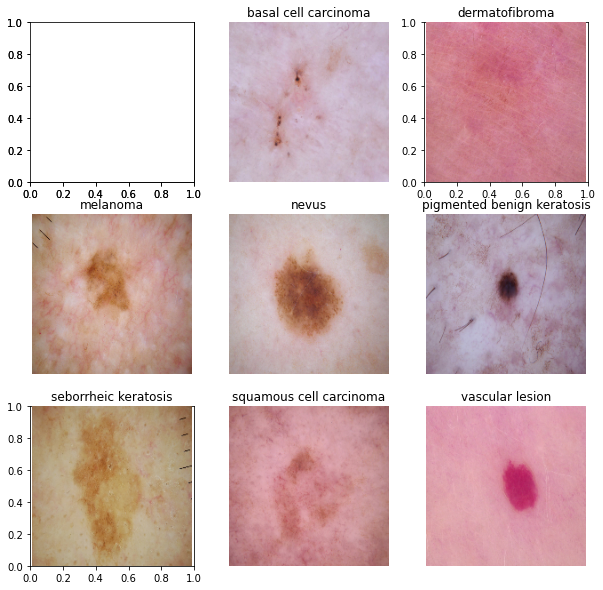

In [23]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

fig = plt.figure(figsize=(10, 10))

classes = range(9)
for images, labels in train_ds.take(2):
    missing = []
    for i in classes:
        ax = fig.add_subplot(3, 3, 1 + i)
        x = np.where(labels[:]==i)[0]
        if len(x) > 0:
            idx = np.where(labels[:]==i)[0][0]
            augmented_images = data_augmentation(images)
            im = images[idx].numpy().astype("uint8")
            plt.imshow(im)
            plt.title(class_names[labels[idx]])
            plt.axis("off")
        else:
            missing.append(i) # Appending list for missing classes
    if len(missing) > 0:
        classes = missing
        continue
    else:
        break

In [24]:
input_batch = ()
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    input_batch = image_batch.shape
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [25]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
## https://www.tensorflow.org/tutorials/images/data_augmentation
## https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomFlip
## Your code goes here
num_classes = 9
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.build(input_batch) 

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 180, 180, 3)         0         
                                                                 
 rescaling_1 (Rescaling)     (32, 180, 180, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (32, 180, 180, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPooling  (32, 90, 90, 16)         0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (32, 90, 90, 32)          4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (32, 45, 45, 32)         0         
 2D)                                                  

In [29]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 3s 39ms/step - loss: 1.9489 - accuracy: 0.2991 - val_loss: 1.6779 - val_accuracy: 0.4161
Epoch 2/20
56/56 [==============================] - 2s 36ms/step - loss: 1.6837 - accuracy: 0.3962 - val_loss: 1.5679 - val_accuracy: 0.4474
Epoch 3/20
56/56 [==============================] - 2s 36ms/step - loss: 1.5244 - accuracy: 0.4464 - val_loss: 1.5934 - val_accuracy: 0.4295
Epoch 4/20
56/56 [==============================] - 2s 36ms/step - loss: 1.4355 - accuracy: 0.4933 - val_loss: 1.4164 - val_accuracy: 0.4944
Epoch 5/20
56/56 [==============================] - 2s 36ms/step - loss: 1.3213 - accuracy: 0.5218 - val_loss: 1.3553 - val_accuracy: 0.5190
Epoch 6/20
56/56 [==============================] - 2s 36ms/step - loss: 1.3473 - accuracy: 0.5329 - val_loss: 1.3751 - val_accuracy: 0.4922
Epoch 7/20
56/56 [==============================] - 2s 36ms/step - loss: 1.3423 - accuracy: 0.5357 - val_loss: 1.3110 - val_accuracy: 0.5324
Epoch 8/20
56

## Visualize training results

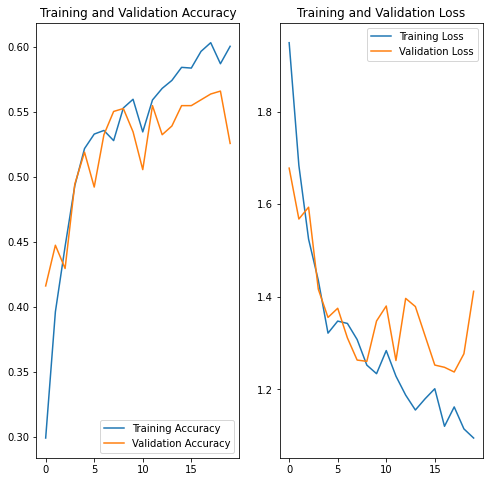

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

After applying data augmentation and tf.keras.layers.Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned.

## Distribution of classes in the training dataset.

In [31]:
#Optional step to get a data frame with a path and label
path_list=[]
lesion_list=[]
for i in class_names:
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
1,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
2,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
3,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
4,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
...,...,...
2234,Skin cancer ISIC The International Skin Imagin...,vascular lesion
2235,Skin cancer ISIC The International Skin Imagin...,vascular lesion
2236,Skin cancer ISIC The International Skin Imagin...,vascular lesion
2237,Skin cancer ISIC The International Skin Imagin...,vascular lesion


<BarContainer object of 9 artists>

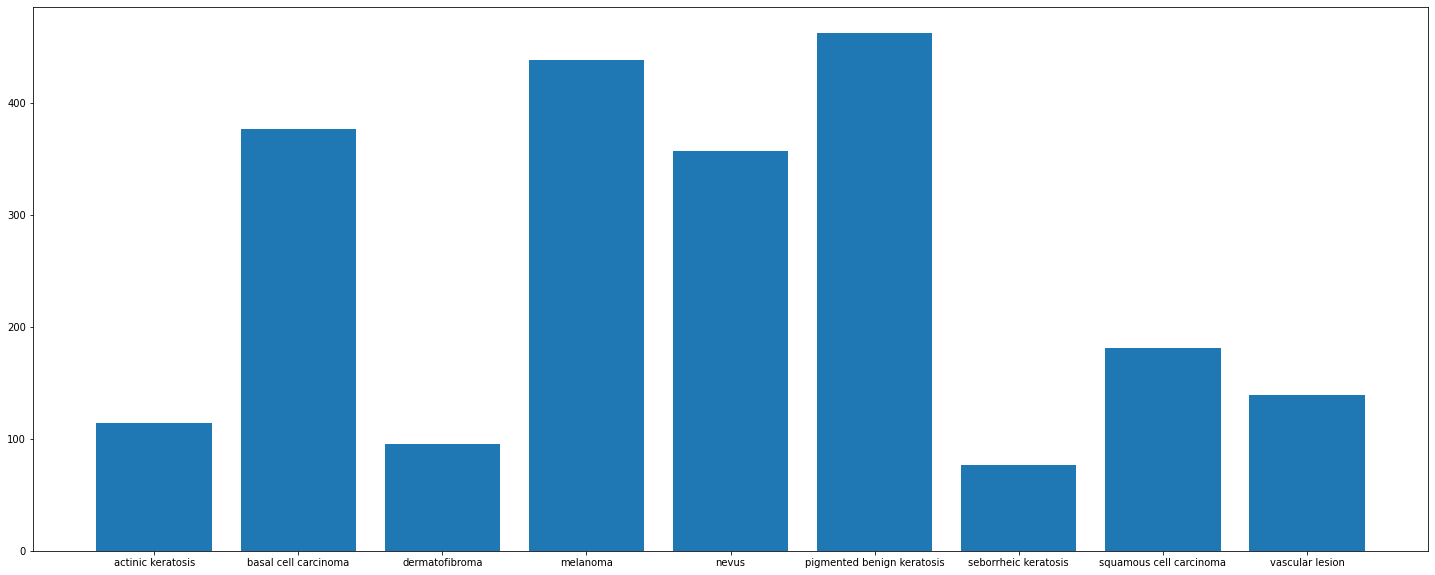

In [32]:
#Visualise the class imbalance
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

## Findings
- Seborrheic keratosis is having the lowest distribution
- Pigmented Benign keratosis is having the highest distribution of data

## Rectify the class imbalance
Context: You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [33]:
!pip install Augmentor

To use Augmentor, the following general procedure is followed:

1. Instantiate a Pipeline object pointing to a directory containing your initial image data set.
2. Define a number of operations to perform on this data set using your Pipeline object.
3. Execute these operations by calling the Pipeline’s sample() method.

In [34]:
import Augmentor
path_to_training_dataset="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability = 0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1C050575F70>: 100%|█| 500/500 [00:03<00:00, 139.74 Samples


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1C043B3CE50>: 100%|█| 500/500 [00:03<00:00, 143.50 Samples


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1C03D39DF70>: 100%|█| 500/500 [00:03<00:00, 145.70 Samples


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1C129C9A820>: 100%|█| 500/500 [00:17<00:00, 28.05 Samples


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x1C0D73709D0>: 100%|█| 500/500 [00:15<00:00, 31.50 Sample


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1C1183B3C40>: 100%|█| 500/500 [00:02<00:00, 169.99 Samples


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1C1306CA340>: 100%|█| 500/500 [00:06<00:00, 72.16 Samples


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1C118414850>: 100%|█| 500/500 [00:02<00:00, 171.64 Samples


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1C129C9DC40>: 100%|█| 500/500 [00:03<00:00, 166.30 Samples


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [35]:
#There should be 4500 classes.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


Lets see the distribution of augmented data after adding new images to the original training data.

In [36]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_55a5377f-08d4-471a-acc2-faa6ec0f421c.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_71890ccd-487a-4faa-9c47-e20b0d05cb68.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_deba1eb8-e0aa-4b91-957b-96412a07bbf0.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_4810d84a-0f7b-4e2f-b265-4840e27fcda0.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_a1f39025-2a1e-46ee-9806-265f2bd378bd.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train

In [37]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [38]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

new_df['Label'].value_counts()

C:\Users\ABHISHEK\AppData\Local\Temp\ipykernel_11960\2005160892.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [39]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output'))]
path_list_new = path_list_new + [x for x in glob(os.path.join(data_dir_train,'*'))]
path_list_new
total = 0
for path in path_list_new:
    print(len(list(pathlib.Path(path).glob('*.jpg'))))
    total = total + len(list(pathlib.Path(path).glob('*.jpg')))
total

500
500
500
500
500
500
500
500
500
114
376
95
438
357
462
77
181
139


6739

Either "inferred" (labels are generated from the directory structure), None (no labels), or a list/tuple of integer labels of the same size as the number of image files found in the directory. Labels should be sorted according to the alphanumeric order of the image file paths 

In [40]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
data_dir_train="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.utils.image_dataset_from_directory(
            data_dir_train,
            labels='inferred', #
            class_names=None,
            color_mode='rgb',
            batch_size=batch_size,
            image_size=(img_height, img_width),
            shuffle=True,
            seed=123,
            validation_split=0.2,
            subset='training',
            interpolation='bilinear',
            follow_links=False,
            crop_to_aspect_ratio=False
            )

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [41]:
val_ds = tf.keras.utils.image_dataset_from_directory(
            data_dir_train,
            labels='inferred', #
            class_names=None,
            color_mode='rgb',
            batch_size=batch_size,
            image_size=(img_height, img_width),
            shuffle=True,
            seed=123,
            validation_split=0.2,
            subset='validation',
            interpolation='bilinear',
            follow_links=False,
            crop_to_aspect_ratio=False
            )

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [42]:
num_classes = 9
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(num_classes)
])

In [43]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [44]:
model.build(input_batch) 

In [45]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (32, 180, 180, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 180, 180, 16)        448       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 90, 90, 16)         0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 90, 90, 32)          4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 45, 45, 32)         0         
 2D)                                                  

In [46]:
#Fit the model through 60 epochs.
epochs = 60
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/60
169/169 [==============================] - 14s 72ms/step - loss: 1.8366 - accuracy: 0.2847 - val_loss: 1.6158 - val_accuracy: 0.3838
Epoch 2/60
169/169 [==============================] - 10s 56ms/step - loss: 1.5732 - accuracy: 0.3863 - val_loss: 1.5279 - val_accuracy: 0.3964
Epoch 3/60
169/169 [==============================] - 10s 56ms/step - loss: 1.4866 - accuracy: 0.4286 - val_loss: 1.4182 - val_accuracy: 0.4662
Epoch 4/60
169/169 [==============================] - 10s 57ms/step - loss: 1.4031 - accuracy: 0.4560 - val_loss: 1.3048 - val_accuracy: 0.4952
Epoch 5/60
169/169 [==============================] - 10s 59ms/step - loss: 1.3331 - accuracy: 0.4777 - val_loss: 1.4181 - val_accuracy: 0.4336
Epoch 6/60
169/169 [==============================] - 10s 58ms/step - loss: 1.3476 - accuracy: 0.4787 - val_loss: 1.2553 - val_accuracy: 0.4952
Epoch 7/60
169/169 [==============================] - 10s 60ms/step - loss: 1.2431 - accuracy: 0.5154 - val_loss: 1.2080 - val_accuracy:

169/169 [==============================] - 11s 64ms/step - loss: 0.2996 - accuracy: 0.8817 - val_loss: 0.5081 - val_accuracy: 0.8307
Epoch 58/60
169/169 [==============================] - 11s 62ms/step - loss: 0.3503 - accuracy: 0.8665 - val_loss: 0.8197 - val_accuracy: 0.7327
Epoch 59/60
169/169 [==============================] - 11s 62ms/step - loss: 0.3009 - accuracy: 0.8828 - val_loss: 0.5965 - val_accuracy: 0.8166
Epoch 60/60
169/169 [==============================] - 11s 63ms/step - loss: 0.2993 - accuracy: 0.8826 - val_loss: 0.4888 - val_accuracy: 0.8456


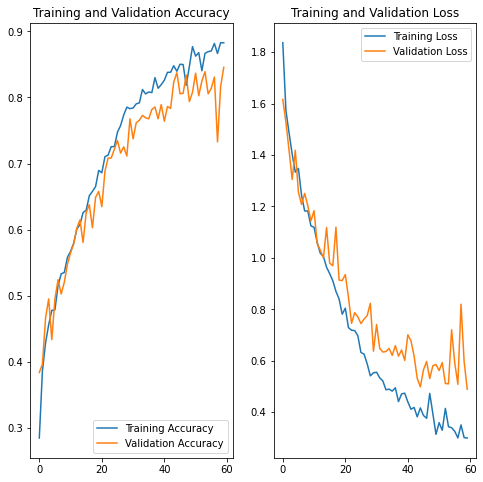

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

Yes class imbalance really helped us getting the accuracy up and then getting the loss down.

In [48]:
test_path  = 'Skin cancer ISIC The International Skin Imaging Collaboration/Test'
test_dir = pathlib.Path(test_path)
img_count_test  = len(list(test_dir.glob('*/*.jpg')))
print('{} test  images'.format(img_count_test))
test_ds  = tf.keras.preprocessing.image_dataset_from_directory(test_dir, image_size=(180,180), seed=123)

118 test  images
Found 118 files belonging to 9 classes.


In [49]:
#Just for rescaling the test image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_generator  = ImageDataGenerator(rescale=1./255)                                    # no aug for test
test_generator  = test_generator.flow_from_directory(test_dir,
                                                     target_size=(180, 180),
                                                     batch_size = 1,                    # using 1 to easily manage mapping between test_gen & pred
                                                     class_mode='categorical',
                                                     color_mode="rgb"
                                                     )

Found 118 images belonging to 9 classes.


In [50]:
print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = model.predict(test_images_ds)

Computing predictions...


In [51]:
score = tf.nn.softmax(probabilities[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to basal cell carcinoma with a 60.74 percent confidence.


In [52]:
score

<tf.Tensor: shape=(9,), dtype=float32, numpy=
array([1.4128995e-01, 6.0744095e-01, 1.4294918e-02, 2.0866819e-02,
       1.2373178e-01, 4.8175659e-02, 1.2414397e-04, 6.6240970e-03,
       3.7451629e-02], dtype=float32)>

In [53]:
probabilities.shape

(118, 9)

In [54]:
# probabilities for each class for first test image
probabilities[0,:]

array([ 0.40958452,  1.8680254 , -1.8813257 , -1.5030694 ,  0.27688664,
       -0.66637576, -6.6275425 , -2.6505156 , -0.9181795 ], dtype=float32)

In [55]:
probabilities[0,:].shape

(9,)

In [56]:
test_ds.class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [57]:
# probability for melanoma class
probabilities[:,4] 

array([ 2.7688664e-01, -5.9249473e-01,  2.2022018e+00,  1.1932484e+01,
        6.4243116e+00,  4.7963600e+00, -6.0397152e+01,  1.3505109e+01,
        3.8793302e+00,  1.8476641e+01, -5.2563496e+00, -7.6015534e+00,
       -3.7270780e+00, -9.7940540e+00,  1.2896329e+00, -8.7158499e+00,
        1.7682770e+01, -1.4991345e+01,  1.0885589e+01, -9.7757406e+00,
       -6.9625487e+00, -4.9705138e+00,  5.3192987e+00,  1.0402431e+01,
        1.8687351e+01,  3.2740304e+00,  1.3671065e+01, -1.3567750e+01,
        2.5863255e+01,  8.0455408e+00,  3.2311618e+00, -1.4056855e+00,
       -1.4939733e+01,  1.2041427e+00,  1.1924890e+00,  3.1974083e-01,
       -3.4677405e+00,  1.0199323e+01,  7.5183077e+00,  7.0775324e-01,
        1.2669388e+00,  1.6678003e+01, -1.2589656e+01,  2.2024384e+00,
       -4.4956484e+00, -9.9214748e-02, -2.5502977e+00, -1.3051436e+01,
        9.7828314e-02, -2.9267392e+00,  1.6172230e+01,  1.4309327e+01,
        2.1400304e+00, -7.9869437e+00, -3.1770387e+00,  2.3313565e+00,
      

In [58]:
probabilities[:,4].shape

(118,)

In [59]:
#Find out score about melanoma of every image
score_all = tf.nn.softmax(probabilities)
score_all[:,4]
score_all_array = score_all[:,4].numpy()
melanoma_percentage = [round(100*score,2) for score in score_all_array]
print(melanoma_percentage)

[12.37, 0.48, 5.75, 95.73, 92.34, 12.21, 0.0, 84.25, 99.65, 99.99, 0.0, 0.0, 0.0, 0.0, 11.99, 0.0, 99.97, 0.0, 99.99, 0.0, 0.0, 0.02, 88.92, 45.91, 99.92, 92.09, 100.0, 0.0, 100.0, 15.21, 40.69, 1.04, 0.0, 6.35, 0.96, 20.35, 0.0, 99.94, 99.48, 0.13, 0.25, 99.99, 0.0, 1.61, 0.0, 0.39, 0.45, 0.0, 17.25, 0.0, 99.97, 99.43, 0.0, 0.0, 0.04, 19.08, 0.0, 99.87, 44.26, 97.7, 94.04, 99.99, 17.72, 0.0, 0.0, 11.6, 2.43, 0.22, 0.0, 99.56, 94.37, 31.76, 0.01, 0.0, 0.0, 0.0, 1.46, 100.0, 99.87, 0.0, 0.0, 0.0, 36.35, 0.0, 0.13, 0.0, 0.02, 0.0, 9.47, 100.0, 24.97, 88.56, 3.08, 0.0, 49.15, 0.32, 3.96, 52.42, 56.05, 86.02, 92.37, 0.01, 23.58, 1.92, 46.02, 0.0, 59.72, 97.52, 32.77, 0.0, 94.82, 2.92, 0.06, 2.19, 0.14, 0.0, 90.5, 99.6]


In [60]:
file_paths = test_ds.file_paths

k = 1
while k<20:
    print(file_paths[k])
    k += 1

Skin cancer ISIC The International Skin Imaging Collaboration\Test\pigmented benign keratosis\ISIC_0024408.jpg
Skin cancer ISIC The International Skin Imaging Collaboration\Test\melanoma\ISIC_0000035.jpg
Skin cancer ISIC The International Skin Imaging Collaboration\Test\pigmented benign keratosis\ISIC_0024358.jpg
Skin cancer ISIC The International Skin Imaging Collaboration\Test\basal cell carcinoma\ISIC_0024454.jpg
Skin cancer ISIC The International Skin Imaging Collaboration\Test\vascular lesion\ISIC_0024402.jpg
Skin cancer ISIC The International Skin Imaging Collaboration\Test\melanoma\ISIC_0000056.jpg
Skin cancer ISIC The International Skin Imaging Collaboration\Test\pigmented benign keratosis\ISIC_0024381.jpg
Skin cancer ISIC The International Skin Imaging Collaboration\Test\pigmented benign keratosis\ISIC_0024422.jpg
Skin cancer ISIC The International Skin Imaging Collaboration\Test\dermatofibroma\ISIC_0001130.jpg
Skin cancer ISIC The International Skin Imaging Collaboration\Test

In [61]:
file_paths[1].split(os.sep)[-1]

'ISIC_0024408.jpg'

In [62]:
print('Generating submission.csv file...')
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(img_count_test))).numpy().astype('U')

img_list = []
img_id_list = []
img_name_list = []
for i in range(len(file_paths)):
    img_list.append(file_paths[i].split(os.sep)[-1])
    img_id_list.append(i)
    img_name_list.append(file_paths[i].split(os.sep)[-1][0:-4])

img_name_list_by_test_ids = []
for iid in list(test_ids):
    print(int(iid),img_name_list[int(iid)],melanoma_percentage[int(iid)]) # here dummy iid got str not int, thus converted
    img_name_list_by_test_ids.append(img_name_list[int(iid)])

Generating submission.csv file...
2 ISIC_0000035 5.75
6 ISIC_0000056 0.0
5 ISIC_0024402 12.21
0 ISIC_0024511 12.37
0 ISIC_0024511 12.37
3 ISIC_0024358 95.73
1 ISIC_0024408 0.48
5 ISIC_0024402 12.21
0 ISIC_0024511 12.37
7 ISIC_0024381 84.25
1 ISIC_0024408 0.48
4 ISIC_0024454 92.34
2 ISIC_0000035 5.75
8 ISIC_0024422 99.65
8 ISIC_0024422 99.65
2 ISIC_0000035 5.75
5 ISIC_0024402 12.21
7 ISIC_0024381 84.25
0 ISIC_0024511 12.37
4 ISIC_0024454 92.34
3 ISIC_0024358 95.73
3 ISIC_0024358 95.73
4 ISIC_0024454 92.34
7 ISIC_0024381 84.25
3 ISIC_0024358 95.73
8 ISIC_0024422 99.65
7 ISIC_0024381 84.25
1 ISIC_0024408 0.48
5 ISIC_0024402 12.21
4 ISIC_0024454 92.34
0 ISIC_0024511 12.37
3 ISIC_0024358 95.73
0 ISIC_0024511 12.37
2 ISIC_0000035 5.75
7 ISIC_0024381 84.25
4 ISIC_0024454 92.34
2 ISIC_0000035 5.75
1 ISIC_0024408 0.48
7 ISIC_0024381 84.25
5 ISIC_0024402 12.21
1 ISIC_0024408 0.48
0 ISIC_0024511 12.37
2 ISIC_0000035 5.75
1 ISIC_0024408 0.48
4 ISIC_0024454 92.34
7 ISIC_0024381 84.25
3 ISIC_0024358

In [63]:
pred_df = pd.DataFrame({'image_name': img_name_list, 'target': melanoma_percentage})
pred_df.head()

,image_name,target
0,ISIC_0024511,12.37
1,ISIC_0024408,0.48
2,ISIC_0000035,5.75
3,ISIC_0024358,95.73
4,ISIC_0024454,92.34


In [64]:
pred_df['target'].unique()

array([1.237e+01, 4.800e-01, 5.750e+00, 9.573e+01, 9.234e+01, 1.221e+01,
       0.000e+00, 8.425e+01, 9.965e+01, 9.999e+01, 1.199e+01, 9.997e+01,
       2.000e-02, 8.892e+01, 4.591e+01, 9.992e+01, 9.209e+01, 1.000e+02,
       1.521e+01, 4.069e+01, 1.040e+00, 6.350e+00, 9.600e-01, 2.035e+01,
       9.994e+01, 9.948e+01, 1.300e-01, 2.500e-01, 1.610e+00, 3.900e-01,
       4.500e-01, 1.725e+01, 9.943e+01, 4.000e-02, 1.908e+01, 9.987e+01,
       4.426e+01, 9.770e+01, 9.404e+01, 1.772e+01, 1.160e+01, 2.430e+00,
       2.200e-01, 9.956e+01, 9.437e+01, 3.176e+01, 1.000e-02, 1.460e+00,
       3.635e+01, 9.470e+00, 2.497e+01, 8.856e+01, 3.080e+00, 4.915e+01,
       3.200e-01, 3.960e+00, 5.242e+01, 5.605e+01, 8.602e+01, 9.237e+01,
       2.358e+01, 1.920e+00, 4.602e+01, 5.972e+01, 9.752e+01, 3.277e+01,
       9.482e+01, 2.920e+00, 6.000e-02, 2.190e+00, 1.400e-01, 9.050e+01,
       9.960e+01])

In [65]:
#Export the prediction data frame to csv
pred_df.to_csv('melanoma_detection.csv')

In [66]:
#Remove all the output folders
import shutil, glob
 
dir = 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/*'
filelist = glob.glob(os.path.join(dir, "*"))
for f in filelist:
    if 'output' in f:
        print(f)
        shutil.rmtree(f)

Skin cancer ISIC The International Skin Imaging Collaboration/Train\actinic keratosis\output
Skin cancer ISIC The International Skin Imaging Collaboration/Train\basal cell carcinoma\output
Skin cancer ISIC The International Skin Imaging Collaboration/Train\dermatofibroma\output
Skin cancer ISIC The International Skin Imaging Collaboration/Train\melanoma\output
Skin cancer ISIC The International Skin Imaging Collaboration/Train\nevus\output
Skin cancer ISIC The International Skin Imaging Collaboration/Train\pigmented benign keratosis\output
Skin cancer ISIC The International Skin Imaging Collaboration/Train\seborrheic keratosis\output
Skin cancer ISIC The International Skin Imaging Collaboration/Train\squamous cell carcinoma\output
Skin cancer ISIC The International Skin Imaging Collaboration/Train\vascular lesion\output
